# CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename = "spam.csv")
data = pd.read_csv("spam.csv", encoding = "latin-1")
print(len(data))

5572


In [9]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


- Unnamed : 2 ~ 4까지 피처 삭제
    
- v1 피처의 ham spam을 0과 1로 변경

In [10]:
del data["Unnamed: 2"]
del data["Unnamed: 3"]
del data["Unnamed: 4"]
data["v1"] = data["v1"].replace(["ham", "spam"], [0, 1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# 중복된 데이터 제거
data.drop_duplicates(subset = ["v2"], inplace = True)
len(data)

5169

In [13]:
# 0과 1의 수 확인
data.groupby("v1").size().reset_index(name = "count")

,v1,count
0,0,4516
1,1,653


In [15]:
X_data = data["v2"]
Y_data = data["v1"]

In [16]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [18]:
sequences[:1]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137]]

In [31]:
X_data = sequences

print("메일 최대 길이 : {}".format(max(len(l) for l in X_data)))
print("메일 평균 길이 : {}".format((sum(map(len, X_data))/len(X_data))))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


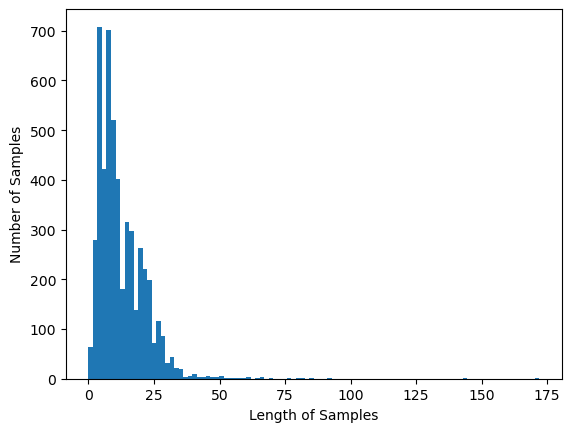

In [32]:
plt.hist([len(s) for s in X_data], bins = 100)
plt.xlabel("Length of Samples")
plt.ylabel("Number of Samples")
plt.show()

- 길이를 60으로 맞추자.

In [33]:
max_len = 60
data = pad_sequences(X_data, maxlen = max_len)
print(data.shape)

(5169, 60)


In [34]:
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) * 0.2)

In [35]:
print(n_train)
print(n_test)

4135
1033


In [39]:
X_train = data[:n_train]
Y_train = np.array(Y_data[:n_train])
X_test = data[n_train:]
Y_test = np.array(Y_data[n_train:])

In [40]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [41]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size = 5, strides = 1, padding = "valid", activation = "relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [47]:
model.compile(optimizer = "adam", 
             loss = "binary_crossentropy",
             metrics = ["acc"])

In [48]:
es = EarlyStopping(patience = 3, restore_best_weights=True)
mc = ModelCheckpoint("isu_best_model.h5", save_best_only = True)
history = model.fit

In [49]:
history = model.fit(X_train, Y_train,
                    epochs = 10, 
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [es, mc])

Epoch 1/10
52/52 [==============================] - 3s 15ms/step - loss: 0.4685 - acc: 0.8652 - val_loss: 0.3757 - val_acc: 0.8730
Epoch 2/10
52/52 [==============================] - 1s 17ms/step - loss: 0.3555 - acc: 0.8697 - val_loss: 0.2918 - val_acc: 0.8730
Epoch 3/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1734 - acc: 0.9296 - val_loss: 0.0857 - val_acc: 0.9758
Epoch 4/10
52/52 [==============================] - 1s 12ms/step - loss: 0.0564 - acc: 0.9840 - val_loss: 0.0570 - val_acc: 0.9807
Epoch 5/10
52/52 [==============================] - 0s 9ms/step - loss: 0.0348 - acc: 0.9906 - val_loss: 0.0509 - val_acc: 0.9794
Epoch 6/10
52/52 [==============================] - 0s 9ms/step - loss: 0.0221 - acc: 0.9937 - val_loss: 0.0508 - val_acc: 0.9819
Epoch 7/10
52/52 [==============================] - 0s 9ms/step - loss: 0.0139 - acc: 0.9964 - val_loss: 0.0513 - val_acc: 0.9770
Epoch 8/10
52/52 [==============================] - 1s 10ms/step - loss: 0.0116 - acc:

In [50]:
model.evaluate(X_test, Y_test)

33/33 [==============================] - 0s 2ms/step - loss: 0.0562 - acc: 0.9816


[0.05618071183562279, 0.9816247820854187]